<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/milestone_project_skim_nlp_lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project: SkimLit 📄 🔥

The pupose of this notebook is to build an NLP mopdel to make reading medial abstarct easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here https://arxiv.org/abs/1710.06071

An reading through the paper above, we see that the model architecture that they use to achiev their best results is available here: https://arxiv.org/abs/1612.05251

# Confirm access to GPU

In [2]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT) , let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 42.53 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by "@"  sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [6]:

# Check all of the filenames in the target directory
import os
filenames = [data_dir + '/' + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize.

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [7]:

# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# Let's read in the trining lines

training_lines = get_lines(filenames[1])
training_lines[:20] # the whole first example of the training data

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [9]:

train_lines = get_lines(data_dir + '/' + "train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look.

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated eith overeating and the development of obesity.\n',
   'total_lines': 11},
...
]

  ```

Let's write a function which turns each of our dtasets into the above format so we can continue to prepare our data for modelling.

In [10]:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples





In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/" + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/" + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "/" + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 435 ms, sys: 101 ms, total: 536 ms
Wall time: 534 ms


(180040, 30212, 30135)

In [12]:

# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [13]:

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

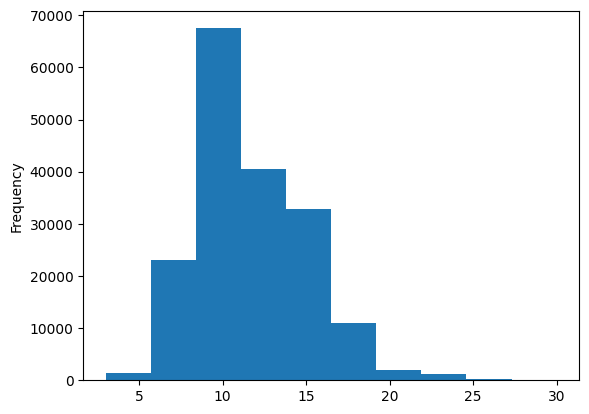

In [15]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

### Get lists of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models required numeric labels)

In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
import sklearn
print(sklearn.__version__)

1.2.2


### Label encode labels

In [20]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of diffferent models and seeing which one works best.

Ans as always we're going to start by building a baseline ([TF-IDF](http://tfidf.com) Multinomial Naive Bayes classifier).

[Chris Albon](https://chrisalbon.com/Home)

## Model 0: Getting a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [225]:
model_0_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [25]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper functions

In the previous module, we wrote functions across different metrics (accuracy, precision, recall, f1-score).

We can download them from GitHub.

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-16 19:13:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-16 19:13:25 (120 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [29]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

Before we start building deper models, we've got to create vectorization and embedding layers.


In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [31]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [32]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

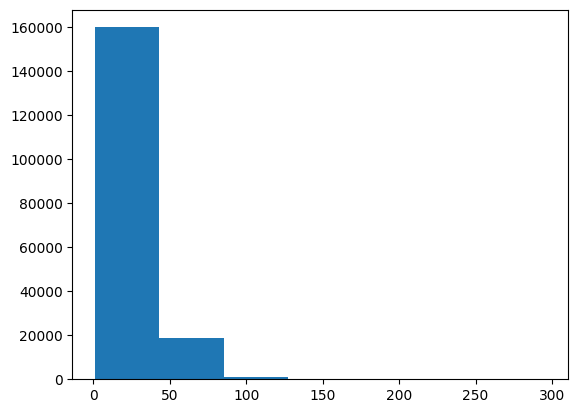

In [33]:
# What's the distribution look like?

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [34]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len


55

In [35]:
# Maximun sequence length in the training set

max(sent_lens)

296

### Create text vectorizer layer

We wnat to make a layer which maps our text from words to numbers.

In [36]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.or/pdf/1710.06071.pdf)

max_tokens = 68000

In [37]:
# create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [38]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [39]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)

print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
elevated plasma osteoprotegerin was associated with ( i ) certain disease characteristics including presence of tissue invasive disease ( p < @ ) and increased viral load at baseline ( p < @ ) , ( ii ) poor virological outcome at day @ after anti-cmv therapy , ( iii ) increased plasma levels of markers of inflammation ( pentraxin @ and c-reactive protein ) and endothelial cell activation ( von willebrand factor ) both at baseline and during follow-up .

Length of text: 81

Vectorized text:
[[  925   249 15649    10    81     7   389  3103   114   395   251   797
      4   669  1213   114    14     3    96  1504  1323    15    49    14
    378   716  3458    86    15   108    21 32666    66   554    96   249
     93     4   747     4   636 19943     3  1371   396     3  1033   507
   1052  7953 12290   432    54    15    49]]


In [40]:
# How many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Get the config ou our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Create a custom text embedding

In [42]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")

Sentence before vectorization:
elevated plasma osteoprotegerin was associated with ( i ) certain disease characteristics including presence of tissue invasive disease ( p < @ ) and increased viral load at baseline ( p < @ ) , ( ii ) poor virological outcome at day @ after anti-cmv therapy , ( iii ) increased plasma levels of markers of inflammation ( pentraxin @ and c-reactive protein ) and endothelial cell activation ( von willebrand factor ) both at baseline and during follow-up .

Sentence after vectorization (before embedding):
[[  925   249 15649    10    81     7   389  3103   114   395   251   797
      4   669  1213   114    14     3    96  1504  1323    15    49    14
    378   716  3458    86    15   108    21 32666    66   554    96   249
     93     4   747     4   636 19943     3  1371   396     3  1033   507
   1052  7953 12290   432    54    15    49]]

Sentence after embedding:
[[[ 0.0364725  -0.04044502 -0.00892013 ...  0.00179312  0.01960495
    0.04493308]
  [-0.0074

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the tensor flow tf.data API, many of the steps here are dicussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [43]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
train_labels_encoded.shape, train_labels_one_hot[0]

((180040,), array([0., 0., 0., 1., 0.]))

In [45]:


# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [46]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [47]:

# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:

# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [49]:
len(train_dataset)

5627

In [50]:


# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 27s 46ms/step - loss: 0.8994 - accuracy: 0.6465 - val_loss: 0.6788 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 24s 42ms/step - loss: 0.6570 - accuracy: 0.7571 - val_loss: 0.6286 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.6185 - accuracy: 0.7707 - val_loss: 0.5975 - val_accuracy: 0.7852


In [51]:
# Evaluate on whole validation set

model_1.evaluate(valid_dataset)

945/945 [==============================] - 2s 3ms/step - loss: 0.5999 - accuracy: 0.7848


[0.5998887419700623, 0.7847874760627747]

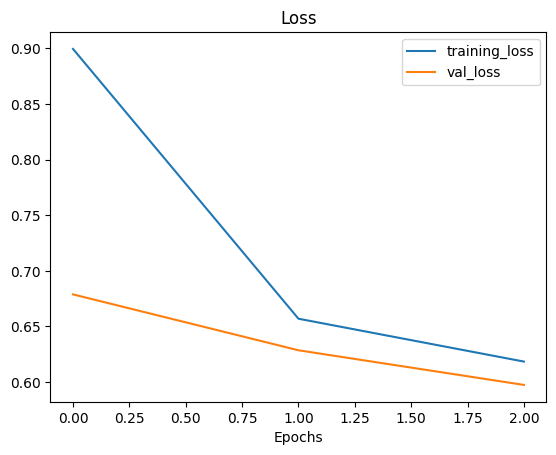

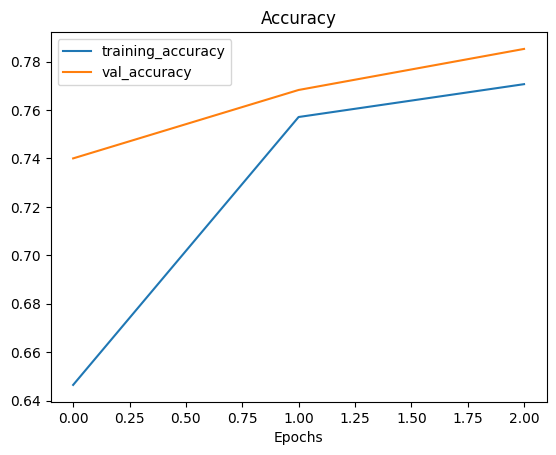

In [52]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_1_history)

In [53]:
# Make predicitons (our model predicition probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.1342750e-01, 1.7592531e-01, 8.6140625e-02, 2.9529205e-01,
         2.9214380e-02],
        [4.7463086e-01, 2.6427749e-01, 1.4094238e-02, 2.3959622e-01,
         7.4011991e-03],
        [1.4839178e-01, 6.3684387e-03, 1.6774265e-03, 8.4352744e-01,
         3.4922297e-05],
        ...,
        [4.8368388e-06, 6.7618093e-04, 7.8323024e-04, 3.3802241e-06,
         9.9853241e-01],
        [5.2232176e-02, 4.6984264e-01, 1.0260859e-01, 5.9492175e-02,
         3.1582439e-01],
        [1.6116966e-01, 7.0757484e-01, 3.6069911e-02, 3.7227698e-02,
         5.7957929e-02]], dtype=float32),
 (30212, 5))

In [54]:
# Convert pred probs to clases
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [227]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7817253088450072,
 'recall': 0.7847875016549716,
 'f1': 0.7822114109096163}

In [55]:
# sho pres as text class
for i in model_1_preds[:20]:
  print(f"Pred: {class_names[i]}")

Pred: BACKGROUND
Pred: BACKGROUND
Pred: OBJECTIVE
Pred: METHODS
Pred: RESULTS
Pred: METHODS
Pred: RESULTS
Pred: METHODS
Pred: RESULTS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: OBJECTIVE
Pred: METHODS
Pred: METHODS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: RESULTS
Pred: CONCLUSIONS


In [56]:
# Calculate model_1 results

model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7817253088450072,
 'recall': 0.7847875016549716,
 'f1': 0.7822114109096163}

## Model 2: Feature extractiion with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specificically the universal sentece encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings. however, we're going to stck with the later created USE pretrained embeding

In [57]:
# Download pretarined TensorFlow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [58]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [59]:
# test out the pretrained embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
elape appears to confer oncological benefit over sape but with notable exceptions , including tumours located above and below the puborectalis sling and anteriorly at the level of prostate where exenteration may be more appropriate .

Sentence after embedding:
[-0.04152626  0.04841696 -0.07808664 -0.07761957 -0.02682755 -0.01713546
 -0.02223629  0.00226895  0.07050689  0.00939292  0.05831984  0.03974143
 -0.07117975  0.00397564  0.04131326 -0.05753135 -0.09205511  0.03803744
 -0.01715564  0.07836131  0.09443741  0.05844553 -0.04903737  0.06191169
  0.03083399  0.07316303 -0.00241723 -0.0589262  -0.0292374   0.01702696]

Length of sentence embedding:
512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [60]:
# Defime feature extraction model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequnece (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note:you could ad more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the outpu layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )

In [61]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [62]:
model_2_history = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 0.9149 - accuracy: 0.6522 - val_loss: 0.7959 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7701 - accuracy: 0.7007 - val_loss: 0.7567 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7555 - accuracy: 0.7102 - val_loss: 0.7436 - val_accuracy: 0.7118


In [63]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.7451 - accuracy: 0.7126


[0.7451037168502808, 0.7126307487487793]

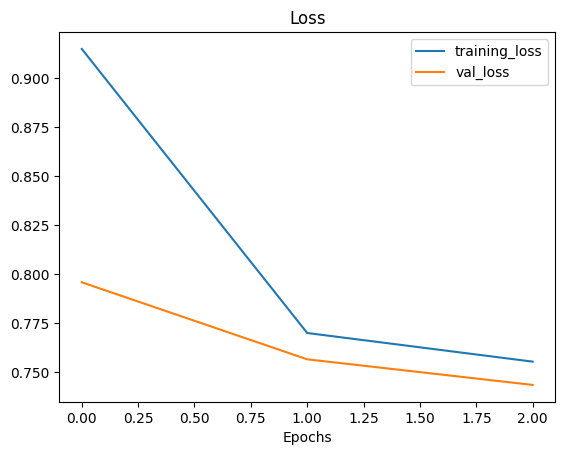

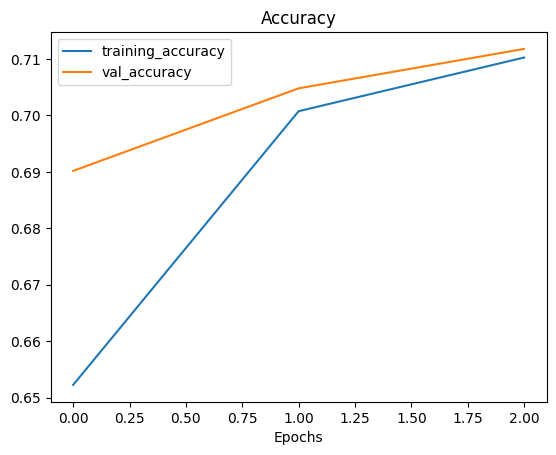

In [64]:
plot_loss_curves(model_2_history)

In [65]:
#Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[4.4811809e-01, 3.5238987e-01, 2.0273170e-03, 1.9032311e-01,
        7.1415715e-03],
       [3.6322412e-01, 4.8002943e-01, 3.8800854e-03, 1.5036689e-01,
        2.4994691e-03],
       [2.3264822e-01, 1.6170794e-01, 1.9486858e-02, 5.4646927e-01,
        3.9687764e-02],
       ...,
       [1.7205121e-03, 6.4845337e-03, 4.6342861e-02, 8.0102897e-04,
        9.4465107e-01],
       [3.7736192e-03, 4.8572529e-02, 2.0645289e-01, 1.1319222e-03,
        7.4006903e-01],
       [1.7554481e-01, 2.0805860e-01, 5.4289579e-01, 7.0352717e-03,
        6.6465475e-02]], dtype=float32)

In [66]:
# Convert the prediciton probabilities found with feature extraction model to labels

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [67]:
# Calculate results from TF Hub prerained embeding rresults on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.26307427512248,
 'precision': 0.7129162445932148,
 'recall': 0.7126307427512247,
 'f1': 0.7096180088896747}

In [68]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [69]:
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7817253088450072,
 'recall': 0.7847875016549716,
 'f1': 0.7822114109096163}

## Model 3: Conv1D with charcter embeddings

The papper which we're replicating states they used a combination of token and character embeddings-level embeddings.

Previously we've token-level embedding but we'll need to do similar steps for characteers if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [70]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [71]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'e l a p e   a p p e a r s   t o   c o n f e r   o n c o l o g i c a l   b e n e f i t   o v e r   s a p e   b u t   w i t h   n o t a b l e   e x c e p t i o n s   ,   i n c l u d i n g   t u m o u r s   l o c a t e d   a b o v e   a n d   b e l o w   t h e   p u b o r e c t a l i s   s l i n g   a n d   a n t e r i o r l y   a t   t h e   l e v e l   o f   p r o s t a t e   w h e r e   e x e n t e r a t i o n   m a y   b e   m o r e   a p p r o p r i a t e   .'

In [72]:
# Split sequence-level data splits into character-level dat splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [73]:
# What's teh average character length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

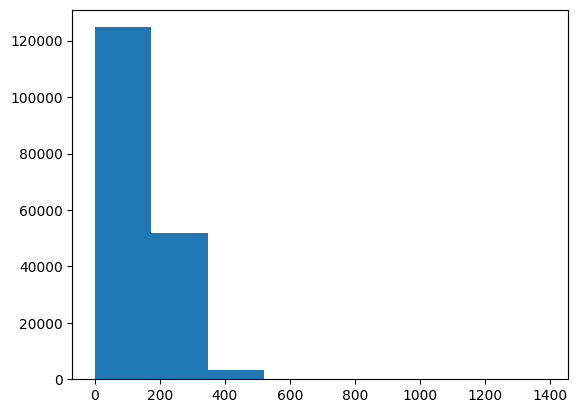

In [74]:
# Check the distribution of our sequencesat a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=8);

In [75]:
# Find what cahracter length covers 95% of sequences

output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [76]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token ( OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    #stanrdize=None, # set standardization to "None" if you wnat to leave ponctuation in
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [78]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [79]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   a i m   o f   t h i s   s t u d y   w a s   t o   e x a m i n e   t h e   e f f e c t s   o f   e n e r g y   a n d   s i n g l e   t r a f f i c   l i g h t   l a b e l l i n g   s y s t e m s   o n   t h e   e n e r g y   c o n t e n t   o f   c h i l d   a n d   a d u l t   i n t e n d e d   f o o d   p u r c h a s e s   .

Length of random_train_chars: 139

Vectorized chars:
 [[ 3 13  2  5  4 15  7 17  3 13  4  9  9  3 16 10 19 20  5  9  3  7  2 24
   5 15  4  6  2  3 13  2  2 17 17  2 11  3  9  7 17  2  6  2  8 18 19  5
   6 10  9  4  6 18 12  2  3  8  5 17 17  4 11 12  4 18 13  3 12  5 22  2
  12 12  4  6 18  9 19  9  3  2 15  9  7  6  3 13  2  2  6  2  8 18 19 11
   7  6  3  2  6  3  7 17 11 13  4 12 10  5  6 10  5 10 16 12  3  4  6  3
   2  6 10  2 10 17  7  7 10 14 16  8 11 13  5  9  2  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0


### Creating a character-level embedding

In [80]:
# Create char embeding layer

char_embed = layers.Embedding(input_dim=len(char_vocab), #number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf
                              mask_zero=False,
                              name="char_embed"
                            )


In [81]:
# test our character embeddig layer

print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   a i m   o f   t h i s   s t u d y   w a s   t o   e x a m i n e   t h e   e f f e c t s   o f   e n e r g y   a n d   s i n g l e   t r a f f i c   l i g h t   l a b e l l i n g   s y s t e m s   o n   t h e   e n e r g y   c o n t e n t   o f   c h i l d   a n d   a d u l t   i n t e n d e d   f o o d   p u r c h a s e s   .

Embedded chars (after vectorization and embedding):
 [[[-0.01391564 -0.00037588 -0.03977702 ... -0.00372897  0.00553268
    0.0324535 ]
  [-0.00196873 -0.00094732 -0.04667414 ... -0.03492606  0.01553928
   -0.03415681]
  [ 0.04614693  0.02295004  0.00363676 ...  0.0279956  -0.02077693
    0.00887204]
  ...
  [-0.04926201 -0.02704467 -0.00871177 ...  0.04230708 -0.01292385
   -0.01757814]
  [-0.04926201 -0.02704467 -0.00871177 ...  0.04230708 -0.01292385
   -0.01757814]
  [-0.04926201 -0.02704467 -0.00871177 ...  0.04230708 -0.01292385
   -0.01757814]]]

Character embedding shape: (1, 290, 25)


In [82]:
len(random_train_chars)

335

### Building a Conv1D model to fit on character embedding

In [94]:
# Make Conv1D on chars only


inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 5

In [95]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2269 - accuracy: 0.5092 - val_loss: 1.0156 - val_accuracy: 0.6097
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9796 - accuracy: 0.6119 - val_loss: 0.9075 - val_accuracy: 0.6546
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9088 - accuracy: 0.6455 - val_loss: 0.8538 - val_accuracy: 0.6702


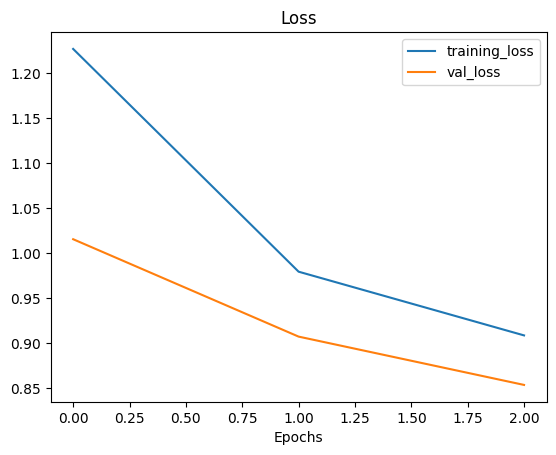

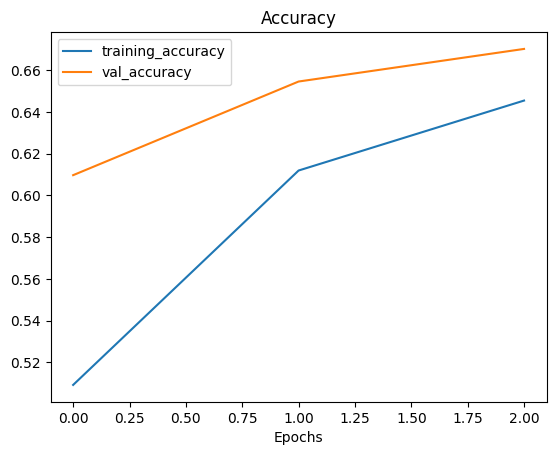

In [97]:
plot_loss_curves(model_3_history)

In [100]:
model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)
model_3_preds

945/945 [==============================] - 2s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [101]:
# Calculate results for Conv1D models chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.71560969151331,
 'precision': 0.6609940371975327,
 'recall': 0.6571560969151331,
 'f1': 0.6467049132197238}

## Model 4: Combining pretrained token embedding + characters embedding (hybrid aproach)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-lev model (similar `model_3` with aslight modifications)
3. Combine 1 & 2 with a conactenate (`tf.keras.layers.Concatenate()`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level dequences as input and produces sequence label probabilities as outputs

In [103]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [104]:
token_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
Total params: 256863488 (979.86 MB)
Trainable params: 65664 (256.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [105]:
# 2. Setup chat inputs model

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [106]:
# 3. Concatenate token and char inputs ( create hybrid token embedding )

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [107]:
# 4. Create output kayers - adding in Dropout, dicussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [108]:
# Construct a model with chr and token inputs

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [109]:
# Compile model

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [110]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [121]:
!pip install pydot
!pip install pydotplus
!pip install graphviz
!sudo apt install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [123]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [124]:
tf.__version__

'2.15.0'

### Combining token and character dat into a tf.data Dataset


In [125]:
# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data

train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make label

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [126]:
# Repeat the above steps for our validation data

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [127]:
# Check out our training char and toekn embedding dataset

train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [128]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 56s 93ms/step - loss: 0.9644 - accuracy: 0.6172 - val_loss: 0.7861 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 52s 92ms/step - loss: 0.7992 - accuracy: 0.6901 - val_loss: 0.7273 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 52s 93ms/step - loss: 0.7749 - accuracy: 0.7017 - val_loss: 0.6994 - val_accuracy: 0.7337


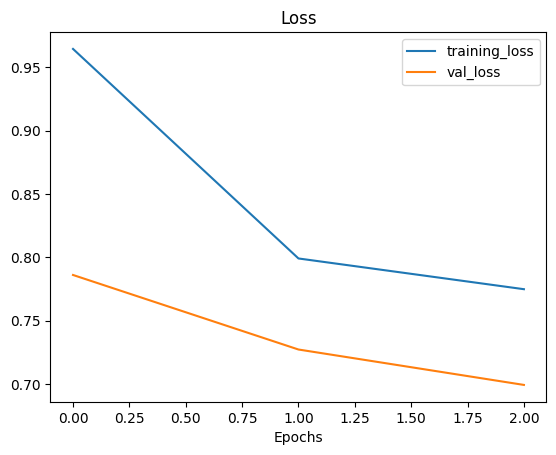

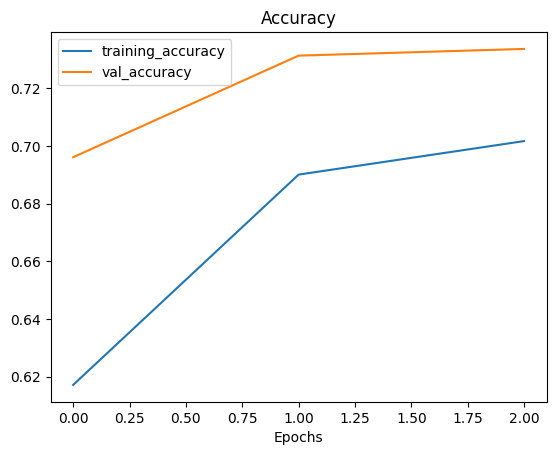

In [129]:
plot_loss_curves(model_4_history)

In [130]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 23ms/step


array([[4.0672776e-01, 3.8055143e-01, 2.6625835e-03, 2.0480131e-01,
        5.2568866e-03],
       [2.7284855e-01, 5.7481796e-01, 2.0297803e-03, 1.4809227e-01,
        2.2115370e-03],
       [3.1082714e-01, 1.6014898e-01, 4.2941093e-02, 4.4060647e-01,
        4.5476213e-02],
       ...,
       [7.8955537e-04, 8.2195830e-03, 5.3003438e-02, 2.3437642e-04,
        9.3775302e-01],
       [6.0383012e-03, 5.9608091e-02, 1.7326558e-01, 1.9965521e-03,
        7.5909150e-01],
       [3.1067014e-01, 3.6503386e-01, 2.6970759e-01, 2.0366469e-02,
        3.4221981e-02]], dtype=float32)

In [131]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=tf.argmax(model_4_pred_probs, axis=1))
model_4_results

{'accuracy': 73.09016284919899,
 'precision': 0.7340834214270681,
 'recall': 0.7309016284919899,
 'f1': 0.7283699801627039}

In [132]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.7021 - accuracy: 0.7309


[0.7021082639694214, 0.7309015989303589]

## Model 5: Transfer learning with pretarined token embedding + character embedding + positional embeddings

In [133]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


from matplotlib import pyplot as plt
_df_0['line_number'].plot(kind='hist', bins=20, title='line_number')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('target').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['line_number']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'line_number'}, axis=1)
              .sort_values('line_number', ascending=True))
  xs = counted['line_number']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('line_number', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('target')):
  _plot_series(series, series_name, i)
  fig.legend(title='target', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('line_number')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['line_number']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'line_number'}, axis=1)
              .sort_values('line_number', ascending=True))
  xs = counted['line_number']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('line_number', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('line_number')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['total_lines']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'total_lines'}, axis=1)
              .sort_values('total_lines', ascending=True))
  xs = counted['total_lines']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('total_lines', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('target')):
  _plot_series(series, series_name, i)
  fig.legend(title='target', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_lines')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['total_lines']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'total_lines'}, axis=1)
              .sort_values('total_lines', ascending=True))
  xs = counted['total_lines']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('total_lines', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('total_lines')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['line_number'].plot(kind='line', figsize=(8, 4), title='line_number')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_8.groupby('target')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('target')
_ = plt.ylabel('text')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='line_number', y='target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='line_number', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

> 🔑 **Note:** Any engineered  features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create position embeddings

In [134]:
# How many diferent line numbrs are there

train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

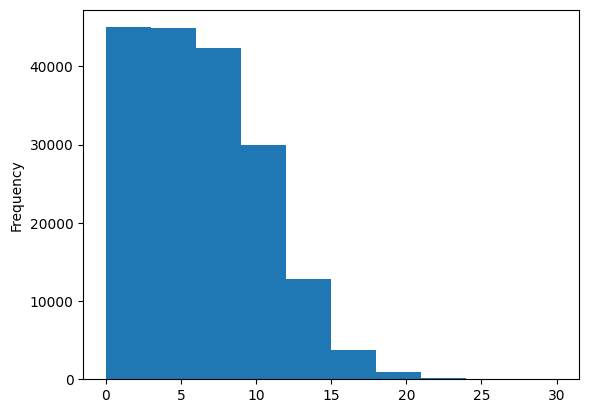

In [135]:
# Check the distribution of  "line_number" column

train_df.line_number.plot.hist();

In [195]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:2], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(2, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [196]:
# How many different numbers of lines are there?

train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

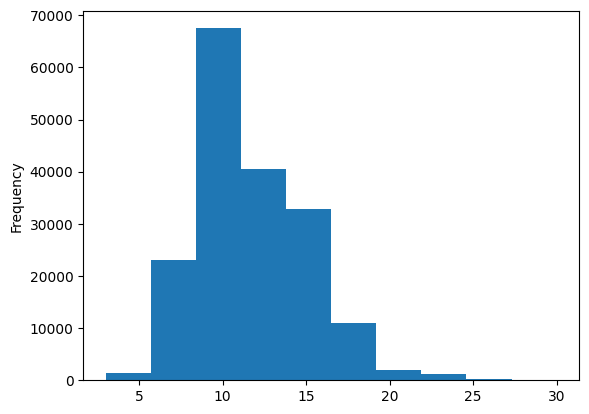

In [197]:
# Cehck the distribution of total lines

train_df.total_lines.plot.hist();

In [198]:
# Check the coverage of a "total_lines" value of 20

np.percentile(train_df.total_lines, 98)

20.0

In [199]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribid embedding model

1. Create a token level model
2. Create a character level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate()
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate()
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inpuof 1, 2, 3, 4 and outputs of into a tf.keras.Model()

In [200]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

In [201]:
token_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_inputs (InputLayer)   [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
Total params: 256863488 (979.86 MB)
Trainable params: 65664 (256.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [202]:
# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [203]:
char_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_inputs (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                14848     
 onal)                                                           
                                                                 
Total params: 15548 (60.73 KB)
Trainable params: 15548 (60.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [204]:
train_line_numbers_one_hot[0].shape, train_total_lines_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [205]:
# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

In [206]:
# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)


In [207]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

In [208]:
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [209]:
# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

In [210]:
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

In [211]:
# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [212]:
model_5.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

In [213]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)


<keras.src.engine.input_layer.InputLayer object at 0x79c3e830e020> True
<keras.src.engine.input_layer.InputLayer object at 0x79c3e82db730> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x79c444791060> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x79c68c647130> False
<keras.src.layers.core.embedding.Embedding object at 0x79c68c6458a0> True
<keras.src.layers.core.dense.Dense object at 0x79c3e830ec50> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x79c3d05c0c40> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x79c3d05e8460> True
<keras.src.engine.input_layer.InputLayer object at 0x79c3d05ebbe0> True
<keras.src.engine.input_layer.InputLayer object at 0x79c3d05ebaf0> True
<keras.src.layers.core.dense.Dense object at 0x79c3e82d9e40> True
<keras.src.layers.core.dense.Dense object at 0x79c3d05e9480> True
<keras.src.layers.core.dense.Dense object at 0x79c3d05e8cd0> True
<keras.src.layers.regularization.dropout.

In [214]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data




In [215]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [216]:

# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 58s 96ms/step - loss: 1.1056 - accuracy: 0.7193 - val_loss: 0.9882 - val_accuracy: 0.8002
Epoch 2/3
562/562 [==============================] - 53s 94ms/step - loss: 0.9706 - accuracy: 0.8126 - val_loss: 0.9527 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 51s 91ms/step - loss: 0.9510 - accuracy: 0.8237 - val_loss: 0.9377 - val_accuracy: 0.8334


In [217]:
model_5_preds = tf.argmax(model_5.predict(val_pos_char_token_dataset), axis=1)
model_5_preds

945/945 [==============================] - 25s 26ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

### Fitting, evaluating and making predicitons with our tribid model

In [226]:
# Calculate reuslts model 5

model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.28147755858599,
 'precision': 0.8315081509827585,
 'recall': 0.8328147755858599,
 'f1': 0.8317395401625567}

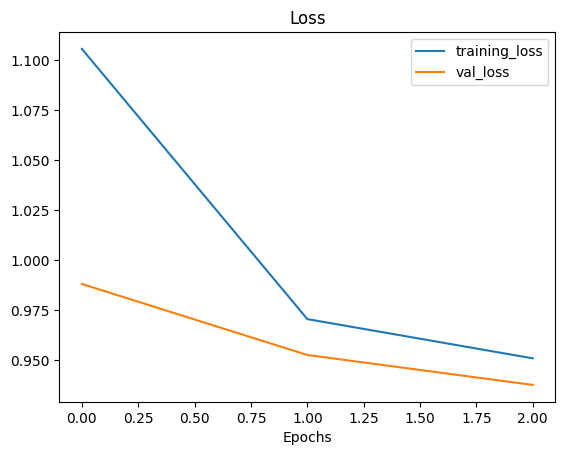

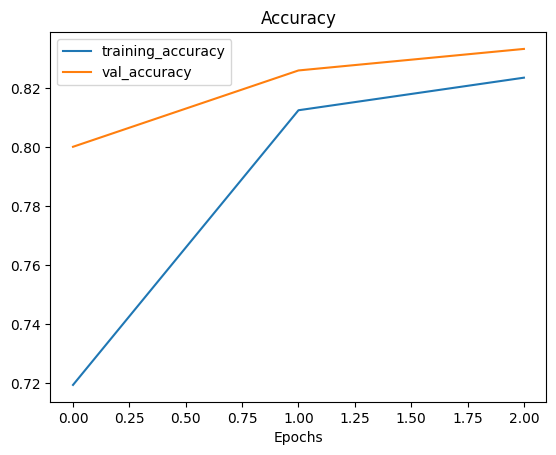

In [219]:
plot_loss_curves(history_model_5)

In [228]:
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "custom_token_embed": model_1_results,
                                  "pretrained_token_embedding": model_2_results,
                                  "custom_char_embedding": model_3_results,
                                  "custom_char_embed": model_4_results,
                                  "tribrid_embed": model_5_results})


all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed,78.478750,0.781725,0.784788,0.782211
pretrained_token_embedding,71.263074,0.712916,0.712631,0.709618
custom_char_embedding,65.715610,0.660994,0.657156,0.646705
custom_char_embed,73.090163,0.734083,0.730902,0.728370
tribrid_embed,83.281478,0.831508,0.832815,0.831740


In [229]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100


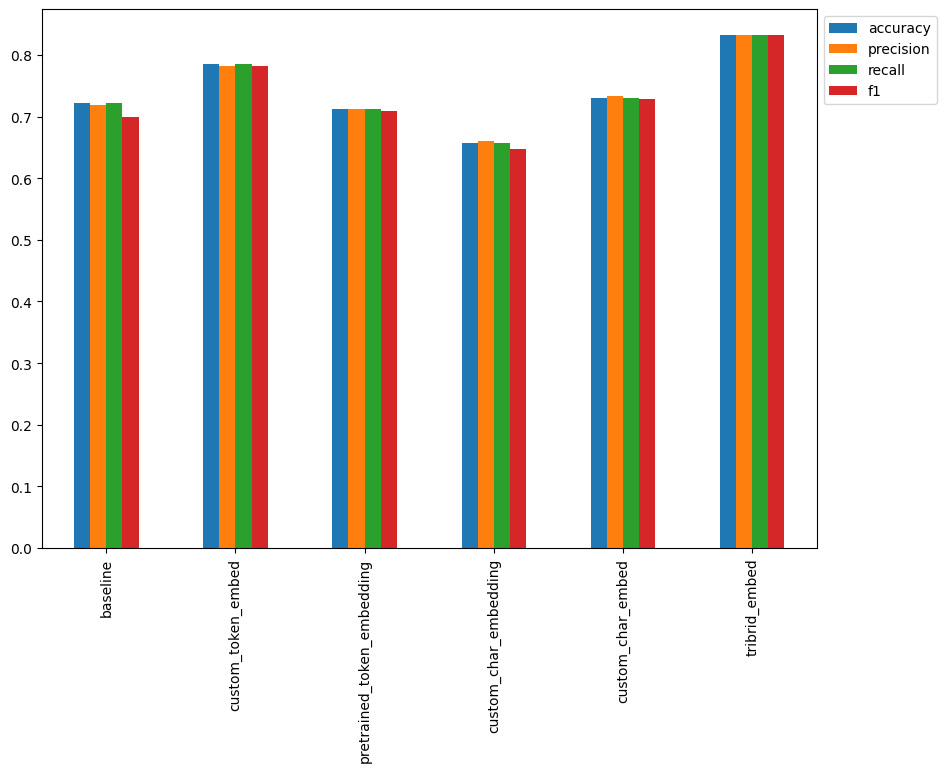

In [230]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

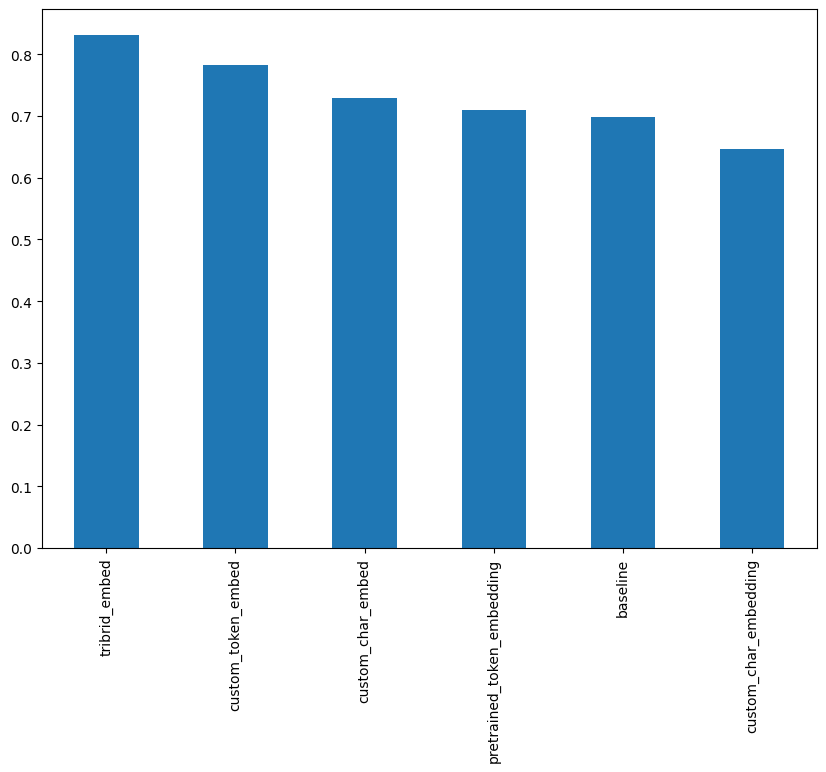

In [231]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save our model

In [232]:
model_5.save("skimlit_tribid_model")

In [233]:
# Load in best performing model

loaded_model = tf.keras.models.load_model("skimlit_tribid_model")

In [234]:
loaded_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

In [235]:
loaded_model_preds = tf.argmax(loaded_model.predict(val_pos_char_token_dataset), axis=1)
loaded_model_preds

945/945 [==============================] - 25s 25ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [236]:
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_model_preds)
loaded_model_results

{'accuracy': 83.28147755858599,
 'precision': 0.8315081509827585,
 'recall': 0.8328147755858599,
 'f1': 0.8317395401625567}

In [237]:
model_5_results == loaded_model_results

True

In [239]:

# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model



--2024-06-16 23:01:38--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 173.194.193.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M   118MB/s    in 8.1s    

2024-06-16 23:01:47 (113 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model

In [240]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,

In [241]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 25s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [242]:

# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [243]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [244]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

In [246]:

# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [247]:

# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 24s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [248]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

In [249]:

%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 6.52 s, sys: 0 ns, total: 6.52 s
Wall time: 6.49 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

In [250]:

# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802458,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


In [251]:

# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918879,False
...,...,...,...,...,...,...,...
12134,RESULTS,we conducted a population-based case-control s...,2,16,METHODS,0.840899,False
2605,RESULTS,"circulating epc ( cells positive for cd@ , cd@...",4,10,METHODS,0.840442,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.840310,False
20003,CONCLUSIONS,most subjects with bronchospasm responded to r...,9,11,RESULTS,0.839986,False
